---
# Amazon Product Reviews Final Project

Will Beeson ('25)

Dartmouth College, Winter 2025

(Professor S. Vosoughi)? 


COSC 74/274: Machine Learning & Statistical Data Analysis

---


## 1. Introduction
**Purpose** 
- In this project, I applied various ML models (binary, multiclass classification, and clustering) to the Amazon product reviews dataset.
- [] Summarize the **dataset** (Training.csv & Test.csv) and the primary challenges (text-based features, multiple tasks, hyperparameter tuning, etc.).
- [] All code uses **Python** and **scikit-learn** ONLY, as per the assignment description.

**Notebook Outline** []
1. [**Data Loading & Exploration**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
2. [**Preprocessing & Feature Engineering**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
3. [**Binary Classification Tasks**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
    - Cutoffs 1, 2, 3, 4
    - At least three classifiers, cross-validation, hyperparameter tuning
4. [**Multiclass Classification**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
    - Five-class (1–5) rating predictions
    - At least three classifiers, cross-validation, hyperparameter tuning
5. [**Clustering**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
    - K-Means on Test.csv reviews
    - Evaluate Silhouette & Rand index
6. [**Kaggle Submission & Results**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
7. [**Conclusion & Future Work**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)

### 1.1 Imports

In [1]:
# Standard library
import os
import sys

In [2]:

os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"

In [ ]:
# Third-party libraries
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import loguniform, randint, uniform

In [ ]:
# Custom text feature engineering module
from feature_engineering_pipeline import (
    preprocess_amazon_reviews,
    SentimentFeatureExtractor
)

In [ ]:
# scikit-learn
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_predict
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    accuracy_score,
    f1_score
)
from sklearn.ensemble import (
    StackingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)


### 1.2 Data Loading & Quick Exploration
**Objectives**
- Load `Training.csv` and `Test.csv`
- Basic check for shapes, missing values, distribution of overall ratins, categories, etc.

In [ ]:
# Load the data
df_train = pd.read_csv("../data/Training.csv")
df_test = pd.read_csv("../data/Test.csv")

# Check basic info
print("Training Shape:", df_train.shape)
print("Test Shape:", df_test.shape)
df_train.head()

**Exploratory Analysis**
- Check for missing values, duplicates, rating distribution
- Plot a histogram of `overall` to see rating imbalance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29189 entries, 0 to 29188
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         29189 non-null  int64  
 1   verified        29189 non-null  bool   
 2   reviewTime      29189 non-null  object 
 3   reviewerID      29189 non-null  object 
 4   asin            29189 non-null  object 
 5   reviewerName    29185 non-null  object 
 6   reviewText      29189 non-null  object 
 7   summary         29183 non-null  object 
 8   unixReviewTime  29189 non-null  int64  
 9   vote            6047 non-null   float64
 10  image           600 non-null    object 
 11  style           15365 non-null  object 
 12  category        29189 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(9)
memory usage: 2.7+ MB


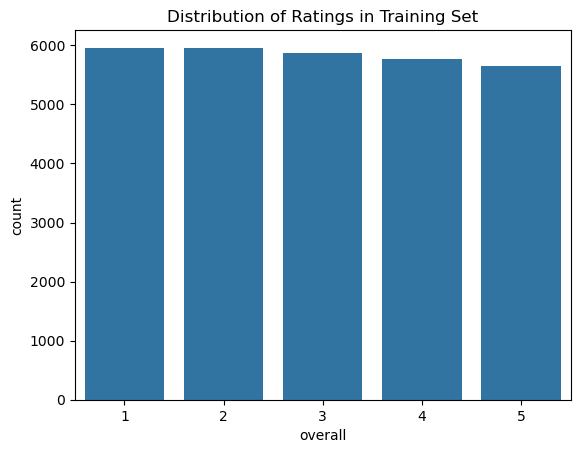

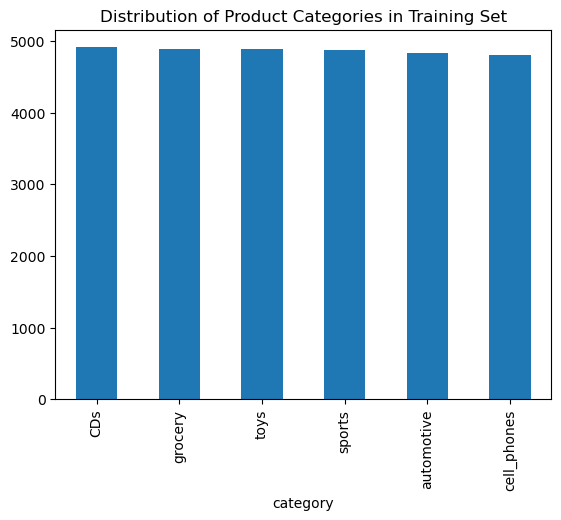

In [6]:
df_train.info()
df_train.isnull().sum()

sns.countplot(data=df_train, x="overall")
plt.title("Distribution of Ratings in Training Set")
plt.show()

# see distribution of categories
df_train["category"].value_counts().plot(kind="bar")
plt.title("Distribution of Product Categories in Training Set")
plt.show()

## 2. Preprocessing & Feature Engineering
**Purpose**:
- Convert reviewText into numerical features (e.g. TF-IDF, CountVectorizer)
- (Optional, potentially later) Add metadata features (like verified, vote, text length) to the pipeline
- (Optional, potentially later) Possibly incorporate ngrams or custom text cleaning.

### Feature Engineering Overview
I developed a custom Python module, `feature_engineering_pipeline.py`, which handles multiple steps of review preprocessing and feature creation. Below is a short description of each major component:

#### 1. `clean_text(text)`
*Removes HTML tags, URLs, and special characters; lowercases and normalizes whitespace.*

```python
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s\'\-]', ' ', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text).strip()         # normalize whitespace
    return text
```

#### 2. `extract_text_statistics(df)`
*Extracts simple numeric features such as review_length, num_words, average word length, uppercase ratio, etc. This helps capture writing style or emphasis.*

```python
def extract_text_statistics(df):
    df['review_length'] = df['reviewText'].apply(len)
    df['num_words'] = df['reviewText'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = ...
    # etc.
    return df
```

#### 3. `SentimentFeatureExtractor`
*A custom scikit-learn transformer class called `SentimentFeatureExtractor` that counts positive/negative words, handles negation words and prefixes, and outputs a polarity score. This is especially helpful to catch phrases like “not good” or “unhappy” without simply counting them as positive.*

```python
class SentimentFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pos_words = {...}
        self.neg_words = {...}
        self.negation_words = {...}
        self.negation_prefixes = {...}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # For each text, tokenize, detect negations, and count pos/neg words
        ...
        return np.column_stack((pos_list, neg_list, pol_list))
```

#### 4. `preprocess_amazon_reviews(df)`
*A higher-level function that runs all the above steps on a DataFrame: it cleans text, extracts text statistics, and (optionally) applies time-based features (I ended up opting to omit time-based features as their effect on model performance was minimal at best). This function produces a processed dataset ready for modeling.*

```python
def preprocess_amazon_reviews(df):
    df = df.copy()
    df["reviewText"] = df["reviewText"].fillna("").apply(clean_text)
    # handle summary, statistics, etc.
    return df
```

Once running `preprocess_amazon_reviews` on the raw CSV data, I can instantiate the `SentimentFeatureExtractor` to generate three additional columns: `pos_count`, `neg_count`, and `polarity_score` (which is `pos_count` - `neg_count`). Below is a quick demonstration of how I tested this sentiment extractor on a few example sentences:


### Sentiment Feature Extraction Test

| reviewText                                         | Expected Sentiment   |   pos_count |   neg_count |   polarity_score |
|:---------------------------------------------------|:---------------------|------------:|------------:|-----------------:|
| I love this product, it's amazing!                 | Positive             |           2 |           0 |                2 |
| This is bad. I hate it!                            | Negative             |           0 |           2 |               -2 |
| Not great, honestly disappointed.                  | Negative             |           1 |           1 |                0 |
| I didn't love this item, I returned it.            | Negative             |           1 |           1 |                0 |
| Absolutely fantastic, best I've ever used!         | Positive             |           2 |           0 |                2 |
| Terrible, absolute junk, do not buy!               | Negative             |        

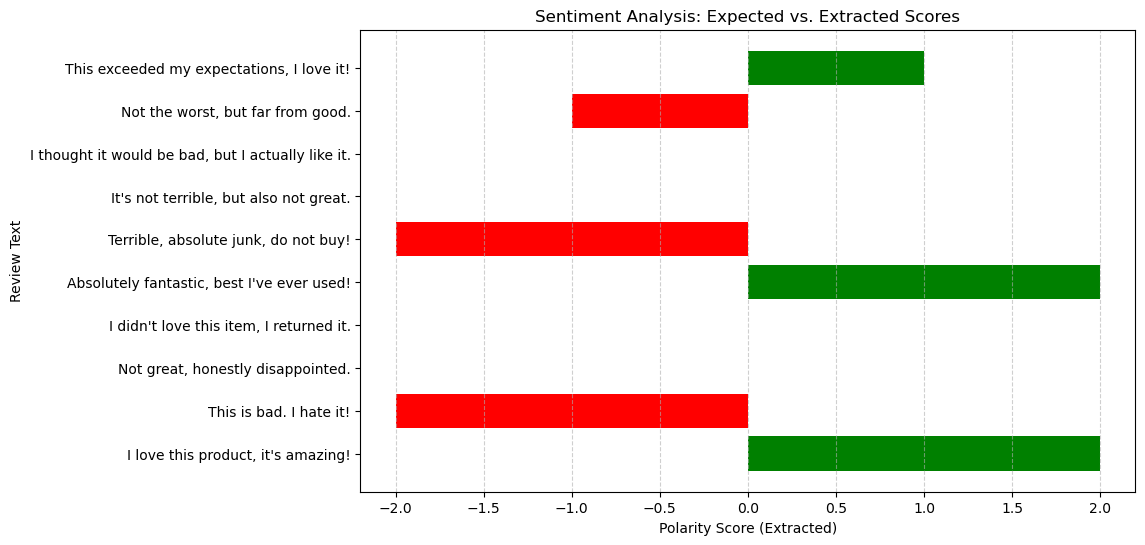

In [7]:
# Test reviews with negation & mixed sentiment cases
test_reviews = [
    "I love this product, it's amazing!",  # Strong Positive
    "This is bad. I hate it!",  # Strong Negative
    "Not great, honestly disappointed.",  # Negation Negative
    "I didn't love this item, I returned it.",  # Negation Negative
    "Absolutely fantastic, best I've ever used!",  # Strong Positive
    "Terrible, absolute junk, do not buy!",  # Strong Negative
    "It's not terrible, but also not great.",  # Neutral
    "I thought it would be bad, but I actually like it.",  # Unexpected Positive
    "Not the worst, but far from good.",  # Slightly Negative
    "This exceeded my expectations, I love it!",  # Strong Positive
]

# Expected sentiment labels for comparison (manual assignment)
expected_sentiment = [
    "Positive", "Negative", "Negative", "Negative", "Positive",
    "Negative", "Neutral", "Positive", "Negative", "Positive"
]

# Convert to DataFrame
df_test = pd.DataFrame({"reviewText": test_reviews, "Expected Sentiment": expected_sentiment})

# Apply sentiment extraction
sentiment_extractor = SentimentFeatureExtractor()
sentiment_array = sentiment_extractor.transform(df_test["reviewText"])

# Convert results to DataFrame for readability
sentiment_df = pd.DataFrame(sentiment_array, columns=["pos_count", "neg_count", "polarity_score"])
df_test = pd.concat([df_test, sentiment_df], axis=1)

# Display results in Markdown Table Format
print("\n### Sentiment Feature Extraction Test\n")
print(df_test.to_markdown(index=False))

# Plot Expected vs. Extracted Sentiment
plt.figure(figsize=(10, 6))
plt.barh(df_test["reviewText"], df_test["polarity_score"], color=["green" if p > 0 else "red" for p in df_test["polarity_score"]])
plt.xlabel("Polarity Score (Extracted)")
plt.ylabel("Review Text")
plt.title("Sentiment Analysis: Expected vs. Extracted Scores")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()


## 3.1 Binary Classification Tasks
The four binary tasks are each defined by a cutoff $c \in {1,2,3,4}$
- Label = 1 if `overall` > c, else 0

### Creating Binary Labels

In [8]:
for cutoff in [1,2,3,4]:
    new_col = f"binary_label_cutoff_{cutoff}"
    df_train[new_col] = (df_train["overall"] > cutoff).astype(int)

# Print class distribution for cutoff=1
print("Class Distribution for Cutoff=1:")
print(df_train["binary_label_cutoff_1"].value_counts(normalize=True))

# Print class distribution for cutoff=2
print("\nClass Distribution for Cutoff=2:")
print(df_train["binary_label_cutoff_2"].value_counts(normalize=True))

# Print class distribution for cutoff=3
print("\nClass Distribution for Cutoff=3:")
print(df_train["binary_label_cutoff_3"].value_counts(normalize=True))

# Print class distribution for cutoff=4
print("\nClass Distribution for Cutoff=4:")
print(df_train["binary_label_cutoff_4"].value_counts(normalize=True))



Class Distribution for Cutoff=1:
binary_label_cutoff_1
1    0.795916
0    0.204084
Name: proportion, dtype: float64

Class Distribution for Cutoff=2:
binary_label_cutoff_2
1    0.591764
0    0.408236
Name: proportion, dtype: float64

Class Distribution for Cutoff=3:
binary_label_cutoff_3
0    0.609065
1    0.390935
Name: proportion, dtype: float64

Class Distribution for Cutoff=4:
binary_label_cutoff_4
0    0.806708
1    0.193292
Name: proportion, dtype: float64


### Training, Cross-Validation, and Reporting
- Report the performance of three different classifiers for each of the four cutoffs
- Define parameter grid for both text vectorizer + classifier hyperparams
- Use 5-fold CV with a metric of `f1_macro`

In [ ]:


# Minimal param grids
param_grids = {
    "logreg": {
        "clf__C": [0.1, 1.0, 10],
        "clf__penalty": ["l2"],       # "l1" requires 'liblinear' or 'saga' solver
    },
    "rf": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [None, 10]
    },
    "gb": {
        "clf__n_estimators": [50, 100],
        "clf__learning_rate": [0.01, 0.1]
    }
}

# Helper function to do the training & evaluation
def run_binary_classification_experiment(df, text_col, label_col, classifier_name):

    # Choose classifier based on string
    if classifier_name == "logreg":
        clf = LogisticRegression(solver="saga", random_state=42, max_iter=2000)
        param_grid = param_grids["logreg"]
    elif classifier_name == "rf":
        clf = RandomForestClassifier(random_state=42)
        param_grid = param_grids["rf"]
    elif classifier_name == "gb":
        clf = GradientBoostingClassifier(random_state=42)
        param_grid = param_grids["gb"]
    else:
        raise ValueError(f"Unknown classifier '{classifier_name}'")

    # Basic pipeline: (1) Tfidf, (2) classifier
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", clf)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="f1_macro",  # we want the best macro-F1
        cv=cv,
        n_jobs=-1,
        verbose=0
    )

    X = df[text_col].astype(str).values
    y = df[label_col].values

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # Generate cross-val predictions (so we can compute confusion matrix, ROC, etc.)
    y_pred = cross_val_predict(best_model, X, y, cv=cv, n_jobs=-1)

    # Metrics
    f1_macro = f1_score(y, y_pred, average="macro")
    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    
    # ROC/AUC requires predicted probs for the positive class
    y_proba = cross_val_predict(best_model, X, y, cv=cv, method="predict_proba", n_jobs=-1)
    fpr, tpr, thresholds = roc_curve(y, y_proba[:,1])
    roc_auc = auc(fpr, tpr)

    print(f"** {classifier_name.upper()} - Best Params: {grid_search.best_params_}")
    print(f"Macro-F1: {f1_macro:.4f} | Accuracy: {acc:.4f} | AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", cm)
    print(classification_report(y, y_pred, digits=4))
    print("-"*60)



In [ ]:

# # Now we loop over the four binary cutoffs, and each of the three classifiers.
# CLASSIFIERS = ["logreg", "rf", "gb"]
# CUTOFFS = [1, 2, 3, 4]

# for cutoff in CUTOFFS:
#     label_col = f"binary_label_cutoff_{cutoff}"
#     print(f"\n{'#'*10}  Results for Cutoff = {cutoff}  {'#'*10}")
#     for clf_name in CLASSIFIERS:
#         run_binary_classification_experiment(
#             df=df_train, 
#             text_col="reviewText", 
#             label_col=label_col, 
#             classifier_name=clf_name
#         )

# # (Optional) You could store these results in a list/dict for later plotting or comparison.

# print("\n#### Next Steps: Stacking Classifier ####")
# print("In an actual Kaggle submission, I would then stack these three best models")
# print("using StackingClassifier, but that's not shown here. This section is left for further work.\n")

In [ ]:
# Binary Cutoff 1
CUTOFF = 1
CLASSIFIERS = ["logreg", "rf", "gb"]

label_col = f"binary_label_cutoff_{cutoff}"
print(f"\n{'#'*10}  Results for Cutoff = {cutoff}  {'#'*10}")

for clf_name in CLASSIFIERS:
    run_binary_classification_experiment(
        df=df_train, 
        text_col="reviewText", 
        label_col=label_col, 
        classifier_name=clf_name
    )


### Evaluating the Best Model & Repeating
- Retreiving the best pipeline found via `grid.best_estimator_`
- Generating confusion matrix, ROC curve, AUC, accuracy, macro F1, etc.

In [ ]:



# Use the best parameters found in 3.2
final_pipeline = Pipeline([
    ("preprocess", TfidfVectorizer(
        ngram_range=(1,2),  
        max_features=10000,
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="l2",
        C=1,
        max_iter=2000,
        class_weight="balanced"
    ))
])

# Train final model
final_pipeline.fit(df_train["reviewText"], df_train["binary_label_cutoff_1"])

# Generate predictions on training set for evaluation
y_pred_c1 = final_pipeline.predict(df_train["reviewText"])
y_proba_c1 = final_pipeline.predict_proba(df_train["reviewText"])[:,1]

# Evaluation metrics
cm = confusion_matrix(df_train["binary_label_cutoff_1"], y_pred_c1)
print("Confusion Matrix:\n", cm)

print("Macro F1:", f1_score(df_train["binary_label_cutoff_1"], y_pred_c1, average='macro'))
print("Accuracy:", accuracy_score(df_train["binary_label_cutoff_1"], y_pred_c1))

roc_auc = roc_auc_score(df_train["binary_label_cutoff_1"], y_proba_c1)
print("ROC AUC:", roc_auc)

# Generate predictions for Kaggle submission
y_test_pred = final_pipeline.predict(df_test["reviewText"])
df_test["binary_split_1"] = y_test_pred

# make sure results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)  

# make sure 'id' column is index of df_test
df_test["id"] = df_test.index 

# Find existing versions and determine new version number (thanks ChatGPT)
base_filename = "submission_cutoff1"
existing_files = [f for f in os.listdir(results_dir) if re.match(f"{base_filename}_v\d+\.csv", f)]
existing_versions = [int(re.search(r'_v(\d+)\.csv', f).group(1)) for f in existing_files if re.search(r'_v(\d+)\.csv', f)]
new_version = max(existing_versions, default=0) + 1

# new file path
submission_path = os.path.join(results_dir, f"{base_filename}_v{new_version}.csv")

# save only 'id' and 'binary_split_1' columns
df_test[["id", "binary_split_1"]].to_csv(submission_path, index=False)

print(f"Submission file for Kaggle saved: {submission_path} 🚀")
